In [177]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
X_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_train.npy")

X_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_val.npy")
Y_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_val.npy")

X_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_test.npy")
Y_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_test.npy")

In [180]:
X_train.shape

(140082, 400, 4)

Text(0.5, 1.0, 'Ch. 3')

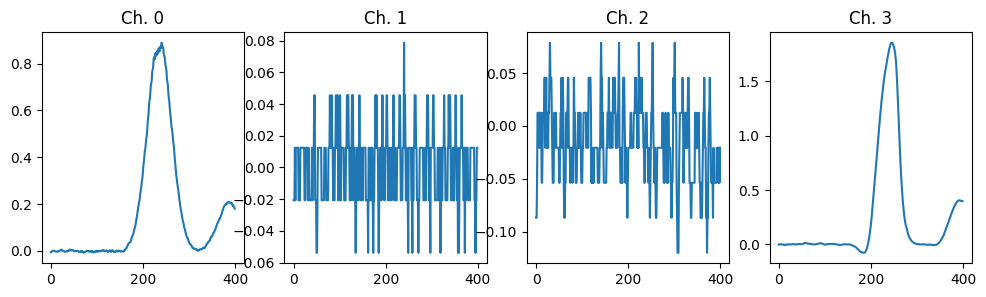

In [181]:
n = random.randint(1, 140081)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

In [182]:
X_train.shape

(140082, 400, 4)

In [183]:
# FIND MAX HEIGHTS ACROSS THE TIME SERIES FOR EACH CHANNEL FOR ALL OF THE PARTICLES

X_train_max_heights = np.zeros((140082, 4))
for p_idx in range (0,140082):
  for c_idx in range(0, 4):
    X_train_max_heights[p_idx][c_idx] = (np.max(X_train[p_idx,:,c_idx]))


X_val_max_heights = np.zeros((70041, 4))
for p_idx in range (0,70041):
  for c_idx in range(0, 4):
    X_val_max_heights[p_idx][c_idx] = (np.max(X_val[p_idx,:,c_idx]))


X_test_max_heights = np.zeros((70042, 4))
for p_idx in range (0,70042):
  for c_idx in range(0, 4):
    X_test_max_heights[p_idx][c_idx] = (np.max(X_test[p_idx,:,c_idx]))

In [184]:
X_test.shape

(70042, 400, 4)

In [185]:
X_test.shape[0]

70042

In [186]:
# METHOD 2: NORMALIZATION OF CHANNEL BY MINIMUM AND MAXIMUM VALUE (COMPUTED ACROSS TRAIN, VALIDATION, AND TEST DATSETS FOR EACH CHANNEL)

def preprocessing(X_data):
  length_data = X_data.shape[0]
  num_channels = X_data.shape[2]

  for p_idx in range(0, length_data):
    for c_idx in range(0, num_channels):
      s0 = (X_data[p_idx,:,c_idx] - combined_channel_min[c_idx])/(combined_channel_max[c_idx]- combined_channel_min[c_idx])
      X_data[p_idx,:,c_idx] = s0

X_all = np.vstack((X_train, X_val, X_test))
X_all.shape

combined_channel_min = np.zeros(4)
combined_channel_max = np.zeros(4)

X_all = np.vstack((X_train, X_val, X_test))

for i in range(4):
  combined_channel_min[i] = np.min(X_all[:, :, i])

for i in range(4):
  combined_channel_max[i] = np.max(X_all[:, :, i])

print(combined_channel_min)
print(combined_channel_max)

preprocessing(X_train)
preprocessing(X_val)
preprocessing(X_test)


[  -2.66666667 -132.52812707 -132.59430841   -5.07434944]
[  3.08825898 132.61664461 132.74487095   5.07434944]


Text(0.5, 1.0, 'Ch. 3')

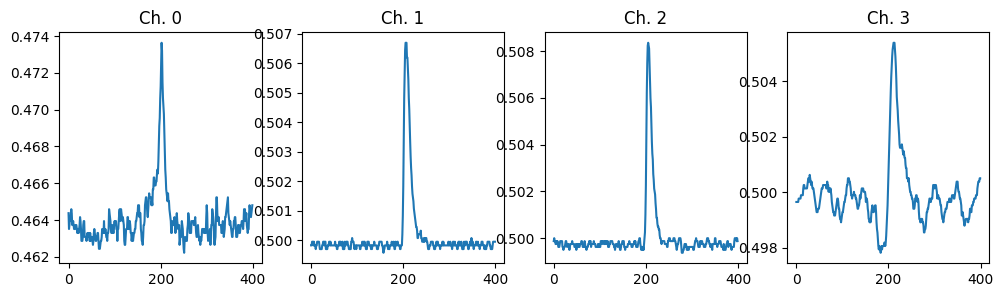

In [187]:
# OBSERVE SCALING OF DATA

n = random.randint(0, 140082)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

In [188]:
X_train.shape

(140082, 400, 4)

In [189]:
# X_train = new_X_train
# X_val = new_X_val
# X_test = new_X_test

In [190]:
X_train.shape

(140082, 400, 4)

In [191]:
X_val.shape

(70041, 400, 4)

In [192]:
X_test.shape

(70042, 400, 4)

In [193]:
# Switch the location of the time axis and channel axis because CNN layers in pytorch expect channels first
tX_train = np.moveaxis(X_train,2,1)
tY_train = Y_train

tX_val = np.moveaxis(X_val,2,1)
tY_val = Y_val

tX_test = np.moveaxis(X_test,2,1)
tY_test = Y_test

In [194]:
dat = X_val
ys = tY_val
i0 = np.min(dat[:,:,0],axis=1)
i1 = np.min(dat[:,:,1],axis=1)
i2 = np.min(dat[:,:,2],axis=1)
i3 = np.min(dat[:,:,3],axis=1)

s0 = np.max(dat[:,:,0],axis=1)
s1 = np.max(dat[:,:,1],axis=1)
s2 = np.max(dat[:,:,2],axis=1)
s3 = np.max(dat[:,:,3],axis=1)

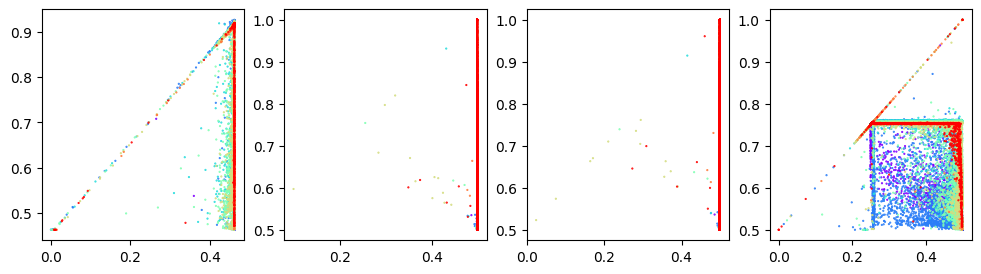

In [195]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].scatter(i0,s0,c=ys,cmap='rainbow',s=0.3)
axes[1].scatter(i1,s1,c=ys,cmap='rainbow',s=0.3)
axes[2].scatter(i2,s2,c=ys,cmap='rainbow',s=0.3)
axes[3].scatter(i3,s3,c=ys,cmap='rainbow',s=0.3)

## Set up the pytorch data loaders

In [196]:
class SP2Datasets(Dataset):
    def __init__(self,purpose,latent=False):

        if purpose == "train":
            self.X = tX_train
            self.Y = tY_train
        elif purpose == "val":
            self.X = tX_val
            self.Y = tY_val
        else:
            self.X = tX_test
            self.Y = tY_test
    def __len__(self):
        return int(self.X.shape[0])
    def __getitem__(self,idx):

        X = self.X[idx,:,:]
        Y = self.Y[idx]

        return X,Y

In [197]:
bs = 500
traindataset = SP2Datasets("train",bs)
valdataset = SP2Datasets("val",bs)
testdataset = SP2Datasets("test",bs)

In [198]:
# disable auto load the data in chunks from memory

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainloader = DataLoader(
    traindataset,
    batch_size=bs,
    shuffle = True,
    #num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

valloader = DataLoader(
    valdataset,
    batch_size=bs,
    shuffle = True,
    #num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

testloader = DataLoader(
    testdataset,
    batch_size=bs,
    shuffle = True,
    #num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)


#trainloader = DataLoader(traindataset, batch_size=bs, shuffle= True )
#valloader = DataLoader(valdataset, batch_size=bs, shuffle=True)
#testloader = DataLoader(testdataset, batch_size=bs, shuffle=True)


In [199]:
i = 0
j = 0
for data in trainloader:
    x,y=data

    #print(x.shape,y.shape)
    i = i+1
    j = j+x.shape[0]
print(i,j)

281 140082


In [200]:
st = 2
c1 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c2 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c3 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c4 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
n_latent = 3
lin = Lin(100,n_latent)

In [201]:
x2 = c1(x.float())
x3 = c2(x2)
x4 = c3(x3)
x5 = c4(x4)
x6 = x5.view(-1,100)
print(x.shape,x2.shape,x3.shape,x4.shape,x5.shape,x6.shape)

torch.Size([82, 4, 400]) torch.Size([82, 4, 200]) torch.Size([82, 4, 100]) torch.Size([82, 4, 50]) torch.Size([82, 4, 25]) torch.Size([82, 100])


## Set up the model

In [202]:
class Encoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(Encoder, self).__init__()
        self.n_layers = 4
        self.n_steps = n_steps
        self.c1 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation1 = ReLU()
        self.c2 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation2 = ReLU()
        self.c3 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation3 = ReLU()
        self.c4 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation4 = ReLU()
        self.lin = Lin(int(self.n_steps/self.n_layers),n_latent)

    def forward(self,x):

        x = self.c1(x)
        x = self.activation1(x)
        x = self.c2(x)
        x = self.activation2(x)
        x = self.c3(x)
        x = self.activation3(x)
        x = self.c4(x)
        x = self.activation4(x)
        x = x.view(-1,int(self.n_steps/self.n_layers))
        return self.lin(x)

class Decoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(Decoder, self).__init__()

        self.n_layers = 4
        self.n_steps = n_steps
        self.n_latent = n_latent
        self.n_channels = n_channels

        self.lin = Lin(n_latent,int(self.n_steps/self.n_layers))
        self.conv1 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation1 = ReLU()
        self.conv2 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation2 = ReLU()
        self.conv3 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation3 = ReLU()
        self.conv4 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation4 = ReLU()
        self.lin2 = Lin(n_steps,n_steps)
        self.activation5 = ReLU()

    def forward(self,x):

        inp = x

        x = self.lin(inp)
        x = x.reshape(-1,self.n_channels,int(self.n_steps/self.n_layers/self.n_channels))
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.conv4(x)
        x = self.activation4(x)

        x = self.lin2(x)

        return x #self.activation5(x)

class SP2AutoEncoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(SP2AutoEncoder, self).__init__()

        self.encoder = Encoder(n_channels=n_channels,n_steps=n_steps,n_latent=n_latent)
        self.decoder = Decoder(n_channels=n_channels,n_steps=n_steps,n_latent=n_latent)

    def forward(self,x):

        bs = x.shape[0]

        latent = self.encoder(x)

        reconstruction = self.decoder(latent) #+x

        return reconstruction,latent

In [203]:
def recon_loss(recon_x,x):
    mseloss = torch.nn.MSELoss()
    mse = mseloss(recon_x,x)

    return mse

In [204]:
def train(model,dataloader,criterion,device,epoch):
    model.train()

    for data in dataloader:
        x,y=data

        optimizer.zero_grad()

        xhat,latent = model(x.float())

        mseloss = recon_loss(xhat,x.float())

        loss = mseloss

        loss.backward()

        optimizer.step()

    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    recon = 0

    with torch.no_grad():
        for data in dataloader:
            x,y=data

            xhat,latent = model(x.float())

            mse = recon_loss(xhat.float(),x.float())

            #correct = correct+loss
            nn = len(dataloader.dataset)
            recon = recon+mse

        return recon/nn

def inference(model,dataloader,device,n_latent=6):
    model.eval()
    dataset = dataloader.dataset
    print(len(dataset))
    bs = 500

    realx = np.zeros((len(dataset),4,400))
    predx = np.zeros((len(dataset),4,400))
    realclasses = np.zeros((len(dataset)))
    latentvars = np.zeros((len(dataset),n_latent))

    jj = 0
    i = 0

    for data in dataloader:

        x,y=data

        xhat,latent = model(x.float())

        bs = xhat.shape[0]
        if xhat is not(None):
            realx[jj:jj+bs,:]=x.cpu().detach().numpy().reshape(bs,4,400)
            predx[jj:jj+bs,:]=xhat.cpu().detach().numpy().reshape(bs,4,400)
            realclasses[jj:jj+bs]=y.cpu().detach().numpy().reshape(bs)
            latentvars[jj:jj+bs,:]=latent.cpu().detach().numpy().reshape(bs,n_latent)

            jj=jj+bs
            i = i+1
        else:
            break

    return realx,predx,realclasses,latentvars

In [205]:
init_lr = 1e-3
weight_decay = 1e-3
total_epochs = 200

# Learning rate strings so its in the correct format for the filenames
lrval='{:3.0e}'.format(init_lr)[0]
lrexp = '{:3.0e}'.format(init_lr)[4]


model = SP2AutoEncoder(n_latent=6)

# Check if there is a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# print(model)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [206]:
val_accur = []
train_accur = []

train_mse_recs = []
val_mse_recs = []

In [207]:
device

device(type='cpu')

In [208]:
e0 = 0
epochs = 60


for epoch in tqdm(range(e0,epochs)):
    mod = train(model,trainloader,criterion,device,epoch)
    train_mse = test(model,trainloader,criterion,device)
    val_mse = test(model,valloader,criterion,device)

    train_mse_recs.append(train_mse)
    val_mse_recs.append(val_mse)
    if epoch%10==0:
      print(f'Epoch: {epoch:03d}, Train MSE: {train_mse:.8e}, Val. MSE: {val_mse:.8e}')

  2%|▏         | 1/60 [00:17<17:26, 17.74s/it]

Epoch: 000, Train MSE: 1.16812689e-05, Val. MSE: 1.17578138e-05


 18%|█▊        | 11/60 [03:09<14:04, 17.24s/it]

Epoch: 010, Train MSE: 1.52403516e-06, Val. MSE: 1.54094209e-06


 35%|███▌      | 21/60 [05:59<11:02, 16.99s/it]

Epoch: 020, Train MSE: 1.09494545e-06, Val. MSE: 1.10700762e-06


 52%|█████▏    | 31/60 [08:48<08:04, 16.71s/it]

Epoch: 030, Train MSE: 9.69715416e-07, Val. MSE: 9.83498808e-07


 68%|██████▊   | 41/60 [11:38<05:22, 16.97s/it]

Epoch: 040, Train MSE: 8.32384103e-07, Val. MSE: 8.39165011e-07


 85%|████████▌ | 51/60 [14:28<02:33, 17.09s/it]

Epoch: 050, Train MSE: 7.94570838e-07, Val. MSE: 8.01431327e-07


100%|██████████| 60/60 [17:01<00:00, 17.02s/it]


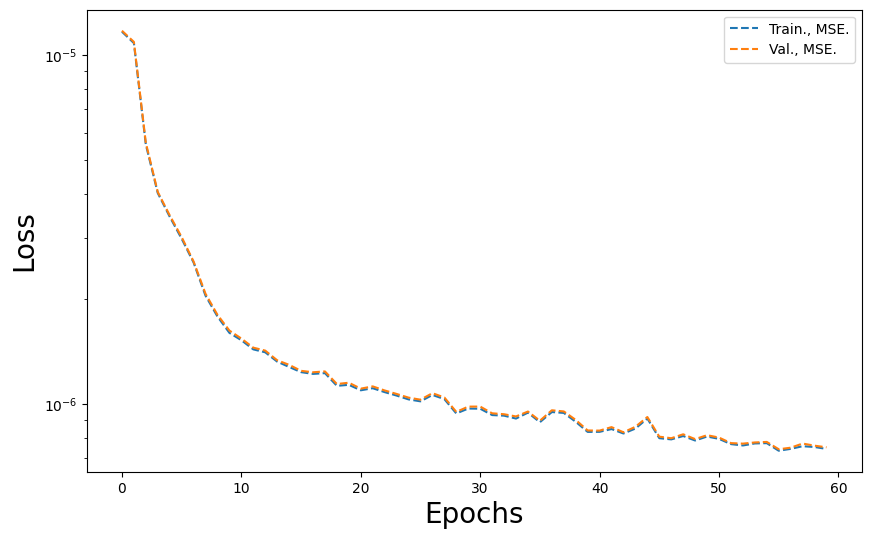

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(train_mse_recs, label='Train., MSE.',linestyle='dashed')
plt.plot(val_mse_recs,label='Val., MSE.',linestyle='dashed')
plt.yscale('log')
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.legend()
plt.show()

In [210]:
trainrealx,trainpredx,trainrealy,trainlatent=inference(model,trainloader,device)
valrealx,valpredx,valrealy,vallatent=inference(model,valloader,device)
testrealx,testpredx,testrealy,testlatent=inference(model,testloader,device)

#trainrealx --> what was being inputted to the vae
#testpredictedx --> 4 channels afte reconstructed from latent variables
#realy --> reall labels of the different aerosols (as a number from 0-7)
#testlatent --> the n_latent we set (2 in this case)
#for the 140,000 signals you ahve two points --> one for latent 1 and latent 2

140082
70041
70042


In [211]:
trainlatent.shape

(140082, 6)

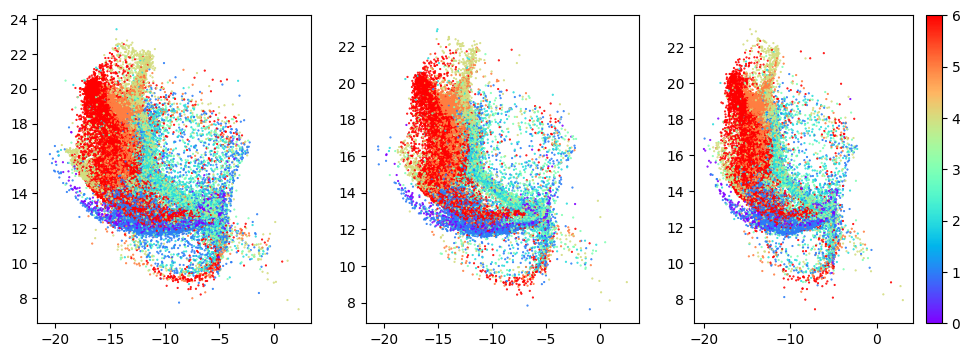

In [212]:
target_names=["FS","FSglyc","CFA","ATD","VA","Fe2O3","Fe3O4"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].scatter(trainlatent[:,0],trainlatent[:,1],c=trainrealy[:],cmap='rainbow',s=0.3)
axes[1].scatter(vallatent[:,0],vallatent[:,1],c=valrealy[:],cmap='rainbow',s=0.3)
ax2=axes[2].scatter(testlatent[:,0],testlatent[:,1],c=testrealy[:],cmap='rainbow',s=0.3)
cbar = plt.colorbar(ax2)
cbar.set_ticklabels=target_names

In [213]:
testrealy.shape

(70042,)

In [214]:
trainrealy.shape

(140082,)

In [215]:
X_test.shape

(70042, 400, 4)

In [216]:
Y_train.shape

(140082,)

In [217]:
Y_test.shape

(70042,)

In [218]:
trainrealy

array([3., 1., 3., ..., 6., 0., 2.])

In [219]:
testlatent[0]

array([ -5.70462894,  12.74097919,  18.4327774 , -15.6365099 ,
        -8.30928898,  -9.63983345])

In [220]:
trainlatent.shape

(140082, 6)

In [221]:
trainlatent.shape

(140082, 6)

In [222]:
testlatent.shape

(70042, 6)

In [223]:
new_X_train = np.concatenate((trainlatent, X_train_max_heights), axis=1)
new_X_test = np.concatenate((testlatent, X_test_max_heights), axis=1)



trainlatent = new_X_train
testlatent = new_X_test

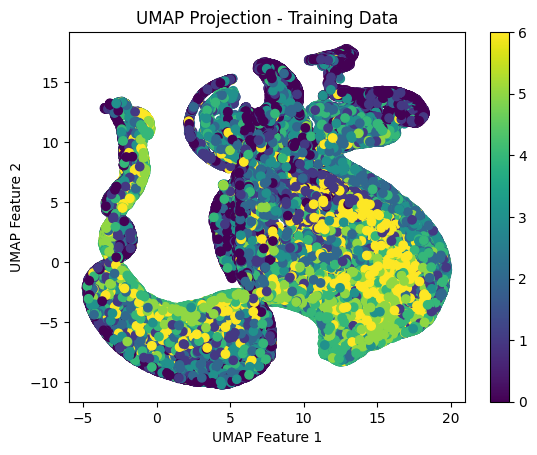

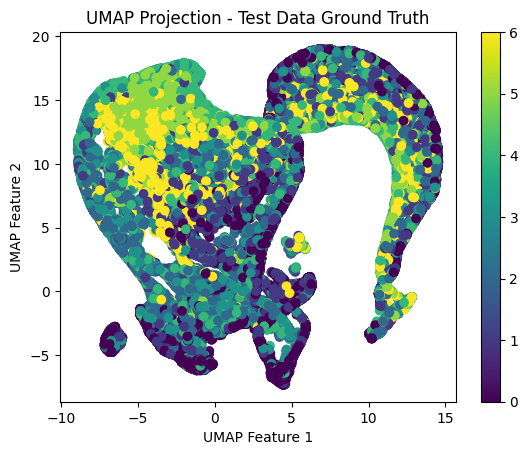

In [224]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function for UMAP visualization
def visualize_umap(X, labels, title):
    # UMAP dimensionality reduction
    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_embeddings = umap_model.fit_transform(X)

    # Visualize the UMAP embeddings with labels
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('UMAP Feature 1')
    plt.ylabel('UMAP Feature 2')
    plt.colorbar()
    plt.show()

# Visualize the training data using UMAP
visualize_umap(trainlatent, trainrealy, 'UMAP Projection - Training Data')

# Visualize the test data using UMAP
visualize_umap(testlatent, testrealy, 'UMAP Projection - Test Data Ground Truth')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


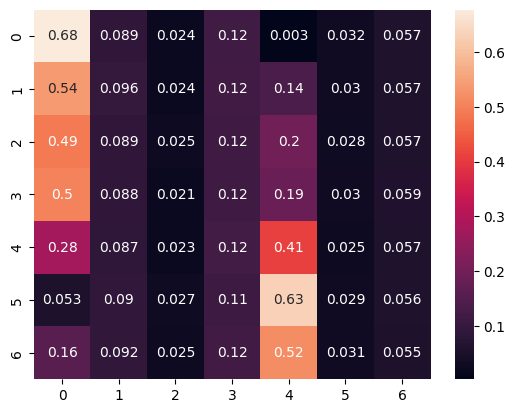

In [225]:
from sklearn.cluster import KMeans
def kmeans(X_train, X_test, train_cluster_labels, test_labels, num_clusters=7):

  # Initialize the k-means clustering model
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)

  kmeans.fit(X_train)

  # Perform clustering on the test data
  test_cluster_labels = kmeans.predict(X_test)

  confusion_matrix = np.zeros((7, 7))

  for point, label, pred_cluster in zip(X_test, testrealy, test_cluster_labels):
    confusion_matrix[int(label)][int(pred_cluster)]+=1

  new_confusion_matrix = np.zeros((7,7))
  for i, row in enumerate(confusion_matrix):
    row_total = sum(row)
    for j, elem in enumerate(row):
      new_confusion_matrix[i][j] = elem/row_total

  sns.heatmap(new_confusion_matrix, annot=True)


kmeans(trainlatent, testlatent, trainrealy, testrealy, 7)

